# Simulation 2: Two-dimensional Gaussian Mixture (PLUS)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error


import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## Problem setup

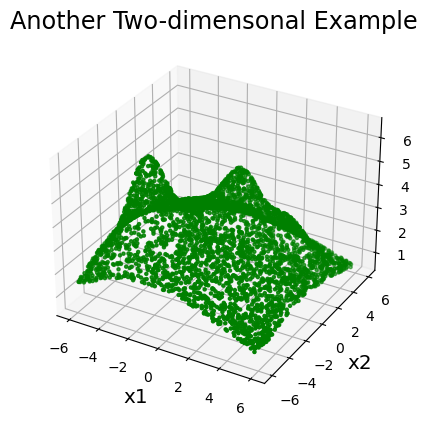

In [2]:
# binary Gaussian
def Gaussian(x, y, x0, y0, sigma):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2.0 * sigma**2))

# parameter
x, y = np.meshgrid(np.linspace(-6, 6), np.linspace(-6, 6))

# calcalation
z = 3*Gaussian(x, y, -3, -3, 2)+2*Gaussian(x, y, 1, 1, 1)+Gaussian(x,y,3,3,1)

np.random.seed(0)
data=12*np.random.rand(5000,2)-6
noise=0.01*np.random.randn(5000)
x=data.T[0]
y=data.T[1]
u=np.random.uniform(0,1,5000)
z = 4*Gaussian(x, y, -1, -1, 5)+3*Gaussian(x, y, -3, -3, 1)+2*Gaussian(x,y,1,1,1)+1*Gaussian(x,y,3,3,1)+noise

# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(x,y,z,marker=".",c="green")
plt.title("Another Two-dimensonal Example",fontsize="xx-large")
plt.xlabel('x1',fontsize="x-large")
plt.ylabel('x2',fontsize="x-large")
plt.show()

## Random Feature

In [3]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

In [4]:
train_x=data
train_y=z
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [5]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    dnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {dnn_trainloss[-1]}
            ''')
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

dnn_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    dnn_x0 = dnn_x0.to(device)
    dnn_pred = net(dnn_x0)

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 2.6270830429977963
            
epoch 100
            Train set - loss: 0.07938034676063901
            
epoch 200
            Train set - loss: 0.035750094784626506
            
epoch 300
            Train set - loss: 0.015093059155138621
            
epoch 400
            Train set - loss: 0.007931771768537054
            
epoch 500
            Train set - loss: 0.0057712910118816905
            
epoch 600
            Train set - loss: 0.004849517412534344
            
epoch 700
            Train set - loss: 0.004382056150149459
            
epoch 800
            Train set - loss: 0.004091691425204399
            
epoch 900
            Train set - loss: 0.003949341938007327
            
epoch 1000
            Train set - loss: 0.0036926888748860234
            
epoch

## 2. Resnet

In [6]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(2,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(2000):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    res_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {res_trainloss[-1]}
            ''')
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

res_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    res_x0 = res_x0.to(device)
    res_pred = net(res_x0)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=2, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3.9143484610790606
            
epoch 100
            Train set - loss: 0.08004864906401818
            
epoch 200
            Train set - loss: 0.019811547582529735
            
epoch 300
            Train set - loss: 0.008014991135831864
            
epoch 400
            Train set - loss: 0.004695156612369512
            
epoch 500
            Train set - loss: 0.0035303593178964148
            
epoch 600
            Train set - loss: 0.00293444886182622
            
epoch 700
            Train set - loss: 0.002642450640669084
            
epoch 800
            Train set - los

# 3. MLKM

In [7]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff1=RandomFourierFeature(2,32,kernel='G',gamma=1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=2)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=-0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

kernel_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1.2848792599271777
            
epoch 100
            Train set - loss: 0.021938644330694434
            
epoch 200
            Train set - loss: 0.010242341400494797
            
epoch 300
            Train set - loss: 0.006916806373468388
            
epoch 400
            Train set - loss: 0.005497828036503806
            
epoch 500
            Train set - loss: 0.004657515760523324
            
epoch 600
            Train set - loss: 0.004142243845612147
            
epoch 700
            Train set - loss: 0.0037398329974223585
            
epoch 800
            Train set - loss: 0.0034304437997111654
            
epoch 900
            Train set - loss: 0.0031713166562329026
            
epoch 1000
            Train set - loss: 0.002949746027326489
            
epoch 1100
            Train set - loss: 0.0027567482050

In [14]:
## reverse
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff1=RandomFourierFeature(2,32,kernel='G',gamma=2)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=-0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
reverse_kernelnn_trainloss=[]
reverse_kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    reverse_kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reverse_kernelnn_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

kernel_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    reverse_kernel_pred = net(kernel_x0)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1.7378778657966214
            
epoch 100
            Train set - loss: 0.13085678311009252
            
epoch 200
            Train set - loss: 0.07595019916964739
            
epoch 300
            Train set - loss: 0.054959995200128245
            
epoch 400
            Train set - loss: 0.045610082448070556
            
epoch 500
            Train set - loss: 0.0401885567456025
            
epoch 600
            Train set - loss: 0.036481676920551744
            
epoch 700
            Train set - loss: 0.033747217640548464
            
epoch 800
            Train set - loss: 0.03151529448507182
            
epoch 900
            Train set - loss: 0.029974899637294754
            
epoch 1000
            Train set - loss: 0.02813643517376746
            
epoch 1100
            Train set - loss: 0.026788921543955922
   

# 4. RKM

In [9]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff0=RandomFourierFeature(2,32,kernel='G',gamma=1)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=2)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initializ
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

rk_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1.360167123897912
            
epoch 100
            Train set - loss: 0.00990766740160651
            
epoch 200
            Train set - loss: 0.00571052642657221
            
epoch 300
            Train set - loss: 0.0037943268815457338
            
epoch 400
            Train set - loss: 0.0027102257149556083
            
epoch 500
            Train set - loss: 0.0021201157057813766
            
epoch 600
            Train set - loss: 0.0017640545494658042
            
epoch 700
            Train set - loss: 0.0015347356210177153
            
epoch 800
            Train set - loss: 0.0014531950376001925
            
epoch 900
            Train set - loss: 0.0012490098845656008
            
epoch 1000
            Train set 

In [24]:
## reverse
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff0=RandomFourierFeature(2,32,kernel='G',gamma=2)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9) #optim.Adam(...)

loss=[]
reverse_reskernel_trainloss=[]
reverse_reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    reverse_reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reverse_reskernel_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

rk_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    reverse_rk_pred = net(rk_x0)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1.142178164936509
            
epoch 100
            Train set - loss: 0.11966550633747275
            
epoch 200
            Train set - loss: 0.054997837250592374
            
epoch 300
            Train set - loss: 0.03894593335380334
            
epoch 400
            Train set - loss: 0.031157844149886454
            
epoch 500
            Train set - loss: 0.024954332281915244
            
epoch 600
            Train set - loss: 0.020394540734521488
            
epoch 700
            Train set - loss: 0.01694140842207051
            
epoch 800
            Train set - loss: 0.014527390621185748
            
epoch 900
            Train set - loss: 0.012868007304274223
            
epoch 1000
            Train set - loss: 

## Comparison

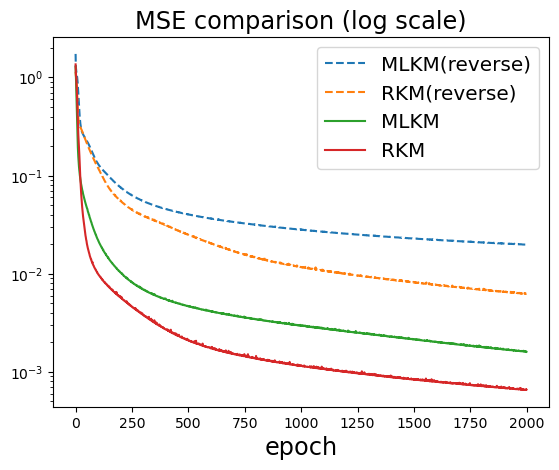

In [25]:
plt.plot(reverse_kernelnn_trainloss,linestyle="--")
plt.plot(reverse_reskernel_trainloss,linestyle="--")
plt.plot(kernelnn_trainloss)
plt.plot(reskernel_trainloss)
plt.legend(["MLKM(reverse)","RKM(reverse)","MLKM","RKM"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.title("MSE comparison (log scale)",fontsize="xx-large")
plt.yscale("log")
plt.show()

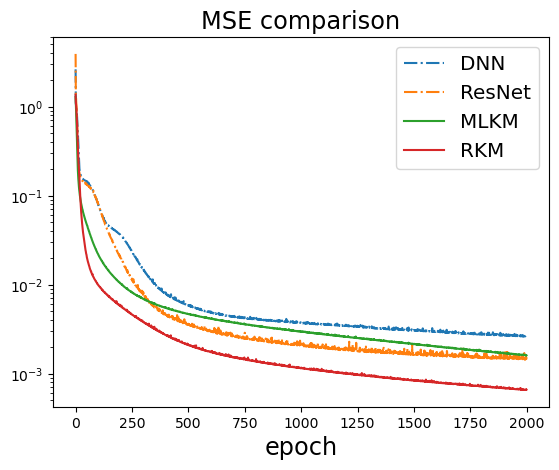

In [26]:
plt.plot(dnn_trainloss,linestyle="-.")
plt.plot(res_trainloss,linestyle="-.")

plt.plot(kernelnn_trainloss)
plt.plot(reskernel_trainloss)
plt.legend(["DNN","ResNet","MLKM","RKM"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.title("MSE comparison",fontsize="xx-large")
plt.yscale("log")
plt.show()

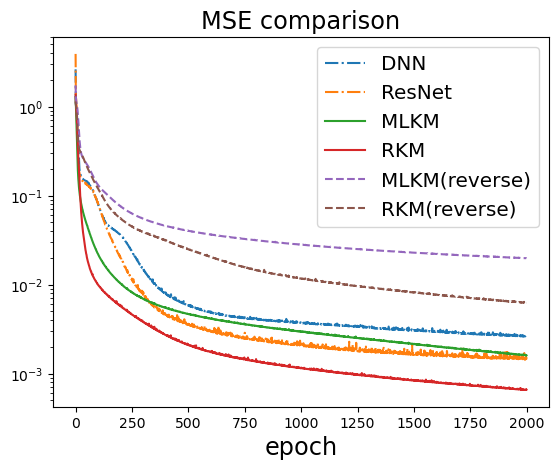

In [27]:
plt.plot(dnn_trainloss,linestyle="-.")
plt.plot(res_trainloss,linestyle="-.")

plt.plot(kernelnn_trainloss)
plt.plot(reskernel_trainloss)
plt.plot(reverse_kernelnn_trainloss,linestyle="--")
plt.plot(reverse_reskernel_trainloss,linestyle="--")
plt.legend(["DNN","ResNet","MLKM","RKM","MLKM(reverse)","RKM(reverse)"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.title("MSE comparison",fontsize="xx-large")
plt.yscale("log")
plt.show()

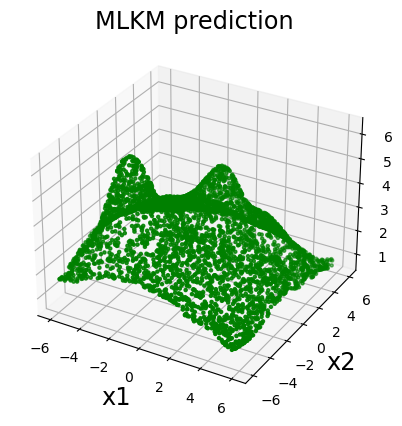

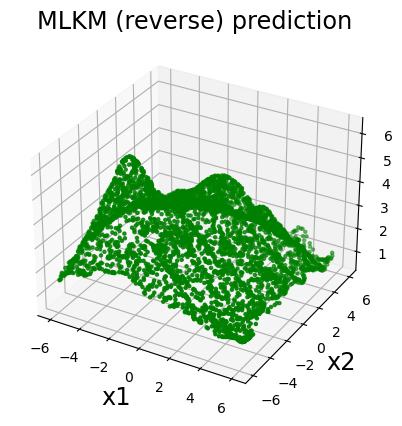

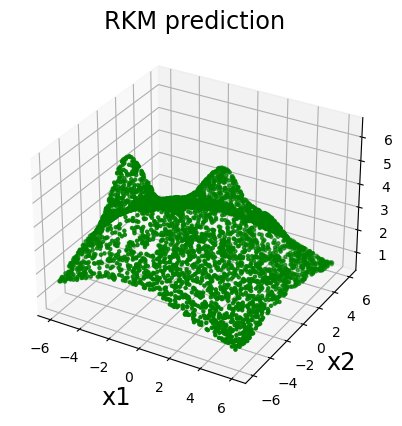

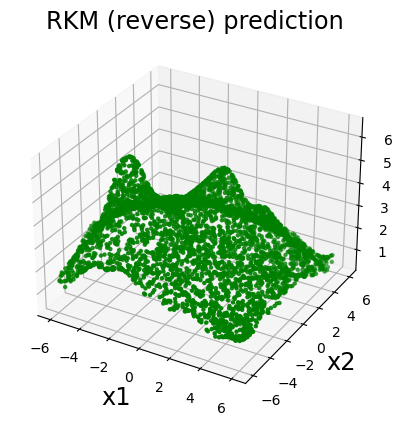

In [28]:
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],kernel_pred,marker=".",c="green")
plt.title("MLKM prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],reverse_kernel_pred,marker=".",c="green")
plt.title("MLKM (reverse) prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],rk_pred,marker=".",c="green")
plt.title("RKM prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()
# 3D plot
ax=plt.axes(projection="3d")
ax.scatter(data.T[0],data.T[1],reverse_rk_pred,marker=".",c="green")
plt.title("RKM (reverse) prediction",fontsize="xx-large")
plt.xlabel('x1',fontsize="xx-large")
plt.ylabel('x2',fontsize="xx-large")
plt.show()